# 期末作业-PUBG Finish Placement Prediction

众所周知，PUBG 曾是一个火遍全球的游戏，玩家们空降到一个孤岛上，最终只有一位（队）玩家获胜，称为“吃鸡”。下面的数据集中提供了 PUBG 的部分战局信息：

https://www.kaggle.com/c/pubg-finish-placement-prediction/data?select=train_V2.csv

请尝试分析该数据集，完成一份数据分析报告，可以从以下角度进行分析：

1. 构建模型，对游戏结果进行预测
2. 提出适合本问题的评价指标，并对模型的预测效果进行评价
3. 试分析对游戏结果影响较大的量，进而分析提高胜率的方法

采用神经网络对实验样本数据进行建模预测：

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import random

读取数据&&数据预处理：

In [2]:
data=pd.read_csv('pubg-finish-placement-prediction/train_V2.csv')
#输出源数据的一些信息
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 29 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Id               1048575 non-null  object 
 1   groupId          1048575 non-null  object 
 2   matchId          1048575 non-null  object 
 3   assists          1048575 non-null  int64  
 4   boosts           1048575 non-null  int64  
 5   damageDealt      1048575 non-null  float64
 6   DBNOs            1048575 non-null  int64  
 7   headshotKills    1048575 non-null  int64  
 8   heals            1048575 non-null  int64  
 9   killPlace        1048575 non-null  int64  
 10  killPoints       1048575 non-null  int64  
 11  kills            1048575 non-null  int64  
 12  killStreaks      1048575 non-null  int64  
 13  longestKill      1048575 non-null  float64
 14  matchDuration    1048575 non-null  int64  
 15  matchType        1048575 non-null  object 
 16  maxPlace         1

(1048575, 29)

可以发现，在一局游戏中，一个玩家记录所产生的数据特别多，为了明确每个数据的意义，下面作出简单说明：

 0   Id               玩家id  object 
 1   groupId         游戏中玩家所在组别的id  object 
 2   matchId          一场游戏的id  object 
 3   assists          助攻数  int64  
 4   boosts           使用的提升类物品数量  int64  
 5   damageDealt      自己承受伤害  float64
 6   DBNOs            击败数  int64  
 7   headshotKills    爆头数  int64  
 8   heals            使用的治疗类物品数  int64  
 9   killPlace        击杀量的排名  int64  
 10  killPoints       击杀点（不太清楚）  int64  
 11  kills            击杀量  int64  
 12  killStreaks      连续击杀数  int64  
 13  longestKill      最远击杀距离  float64
 14  matchDuration    匹配时间  int64  
 15  matchType        比赛类型  object 
 16  maxPlace         对大的队伍排名  int64  
 17  numGroups        一局比赛中队伍的数量  int64  
 18  rankPoints       排名点  int64  
 19  revives          救活队友的数量  int64  
 20  rideDistance     使用交通工具骑行的距离  float64
 21  roadKills         使用交通工具杀死的玩家数 int64  
 22  swimDistance     游泳的距离  float64
 23  teamKills        团队击杀量  int64  
 24  vehicleDestroys  交通工具毁坏数  int64  
 25  walkDistance     步行的距离  float64
 26  weaponsAcquired  装备获得数  int64  
 27  winPoints        胜利点  int64  
 28  winPlacePerc     排名预测  float64

为了将问题简化，我们只考虑一个玩家在游戏中自己和团队的行为，而不考虑他匹配到了什么队友，或者什么敌人虽然这对比赛结果有一定影响。因此我们需要剔除一些相关的属性，最后只留下了（3，4，5，6，7，8，9，11，12，13，14，15，16，17，19，20，21，22，23，24，25，26，28）序号的属性。

需要注意的是击杀点，排名点，胜利点都是对局结束后，系统基于玩家行为给出的评分，因此不纳入预测改局比赛的影响因素。

In [3]:
col=['assists','boosts','damageDealt','DBNOs','headshotKills','heals','killPlace','kills','killStreaks','longestKill','matchDuration','matchType','maxPlace','numGroups','revives','rideDistance','roadKills','swimDistance','roadKills','vehicleDestroys','walkDistance','weaponsAcquired','winPlacePerc']
data=data[col]
data.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,numGroups,revives,rideDistance,roadKills,swimDistance,roadKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,0.00,0,0,0,60,0,0,0.00,...,26,0,0.0000,0,0.00,0,0,244.80,1,0.4444
1,0,0,91.47,0,0,0,57,0,0,0.00,...,25,0,0.0045,0,11.04,0,0,1434.00,5,0.6400
2,1,0,68.00,0,0,0,47,0,0,0.00,...,47,0,0.0000,0,0.00,0,0,161.80,2,0.7755
3,0,0,32.90,0,0,0,75,0,0,0.00,...,30,0,0.0000,0,0.00,0,0,202.70,3,0.1667
4,0,0,100.00,0,0,0,45,1,1,58.53,...,95,0,0.0000,0,0.00,0,0,49.75,2,0.1875


其中matchType中的数据不是数值类型，因此需要将它转换

In [4]:
keys = list(set(data['matchType']))
values = range(len(keys))
d=dict(zip(keys, values))
print("对应关系：",d)
data = data.applymap(lambda x: d[x] if  x in d.keys() else x)

对应关系： {'duo': 0, 'normal-duo': 1, 'duo-fpp': 2, 'solo-fpp': 3, 'squad': 4, 'normal-squad-fpp': 5, 'flaretpp': 6, 'normal-solo-fpp': 7, 'normal-solo': 8, 'normal-duo-fpp': 9, 'normal-squad': 10, 'crashtpp': 11, 'squad-fpp': 12, 'flarefpp': 13, 'solo': 14, 'crashfpp': 15}


数据标准化：这样做是为了使训练很快收敛

对每一列属性$y_{ij}$，$\frac{y_{ij}^*=y_{ij}-\bar{y_i·}}{std_jy_{ij}}$

In [5]:
train_data = np.array(data)
#对数据中心化处理,除了标签winPlacePerc
n,l=train_data.shape
for j in range(l-1):
    meanVal=np.mean(train_data[:,j])
    stdVal=np.std(train_data[:,j])
    train_data[:,j]=(train_data[:,j]-meanVal)/stdVal

划分训练集和测试集：

In [6]:
print(train_data.shape)

(1048575, 23)


一共有1048575条数据，选择其中1000000条作为训练集，48575条作为测试集

In [7]:
#打乱数据
np.random.shuffle(train_data)

train=train_data[0:1000000]
print(train.shape)
test=train_data[1000000:1048576]
print(test.shape)
#标签和属性分开存储
train_x = train[:, :22]
train_y = train[:, 22]
test_x = test[:, :22]
test_y = test[:, 22]
print(train_y)

(1000000, 23)
(48575, 23)
[0.     0.6304 0.4348 ... 0.1489 0.1034 0.1852]


构建神经网，并且开始训练：

网络结构定义：

In [8]:
import torch
from torch import nn
# 定义模型

class Net(nn.Module):
    #初始化网络结构
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) #输入层，线性（liner）关系
        self.relu = nn.ReLU()#隐藏层，使用ReLU函数
        self.fc2 = nn.Linear(hidden_size, num_classes)  #输出层，线性（liner）关系
        self.sigmoid=nn.Sigmoid()
    #forword 参数传递函数，网络中数据的流动
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out=self.sigmoid(out)
        out = out.squeeze(-1)


        return out
    
net = Net(22, 10, 1)

criterion=criterion=nn.MSELoss(reduction='mean') # 使用MSE损失
optm=torch.optim.Adam(net.parameters())#Adam优化器

Epoch:0,Loss:0.0894
Epoch:50,Loss:0.0550
Epoch:100,Loss:0.0382
Epoch:150,Loss:0.0283
Epoch:200,Loss:0.0223
Epoch:250,Loss:0.0192
Epoch:300,Loss:0.0175
Epoch:350,Loss:0.0163
Epoch:400,Loss:0.0154
Epoch:450,Loss:0.0147
Epoch:500,Loss:0.0141
Epoch:550,Loss:0.0136
Epoch:600,Loss:0.0133
Epoch:650,Loss:0.0129
Epoch:700,Loss:0.0127
Epoch:750,Loss:0.0124
Epoch:800,Loss:0.0122
Epoch:850,Loss:0.0120
Epoch:900,Loss:0.0119
Epoch:950,Loss:0.0117
Epoch:1000,Loss:0.0115
Epoch:1050,Loss:0.0114
Epoch:1100,Loss:0.0113
Epoch:1150,Loss:0.0111
Epoch:1200,Loss:0.0110
Epoch:1250,Loss:0.0109
Epoch:1300,Loss:0.0108
Epoch:1350,Loss:0.0108
Epoch:1400,Loss:0.0107
Epoch:1450,Loss:0.0106
Epoch:1500,Loss:0.0105
Epoch:1550,Loss:0.0104
Epoch:1600,Loss:0.0103
Epoch:1650,Loss:0.0102
Epoch:1700,Loss:0.0101
Epoch:1750,Loss:0.0101
Epoch:1800,Loss:0.0100
Epoch:1850,Loss:0.0099
Epoch:1900,Loss:0.0099
Epoch:1950,Loss:0.0098
Epoch:2000,Loss:0.0098
Epoch:2050,Loss:0.0097
Epoch:2100,Loss:0.0097
Epoch:2150,Loss:0.0096
Epoch:2200,

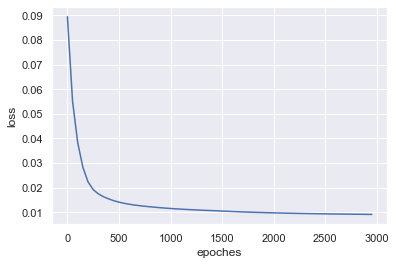

In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#训练
epochs=3000 # 训练3000次

losses=[]
for i in range(epochs):
    # 指定模型为训练模式，计算梯度
    net.train()
    # 输入值都需要转化成torch的Tensor
    x=torch.from_numpy(train_x).float()
    y=torch.from_numpy(train_y).float()
    y_hat=net(x)
    loss=criterion(y_hat,y) # 计算损失
    
    optm.zero_grad() # 前一步的损失清零
    loss.backward() # 反向传播
    optm.step() # 优化
    
    if (i)%50 ==0 : # 这里我们每100次输出相关的信息
        # 指定模型为计算模式
        net.eval()
        test_in=torch.from_numpy(test_x).float()
        test_l=torch.from_numpy(test_y).float()
        test_out=net(test_in)
        # 使用我们的测试函数损失值
        losses.append(loss.item())
        print("Epoch:{},Loss:{:.4f}".format(i,loss.item()))
plt.plot([i*50 for i in range(0,60)],losses)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()

最终损失值收敛到0.009左右

为了得到，和比赛结果最相关的因素，现在计算各个因素之间的相关矩阵，并且输出热力图：

<AxesSubplot:>

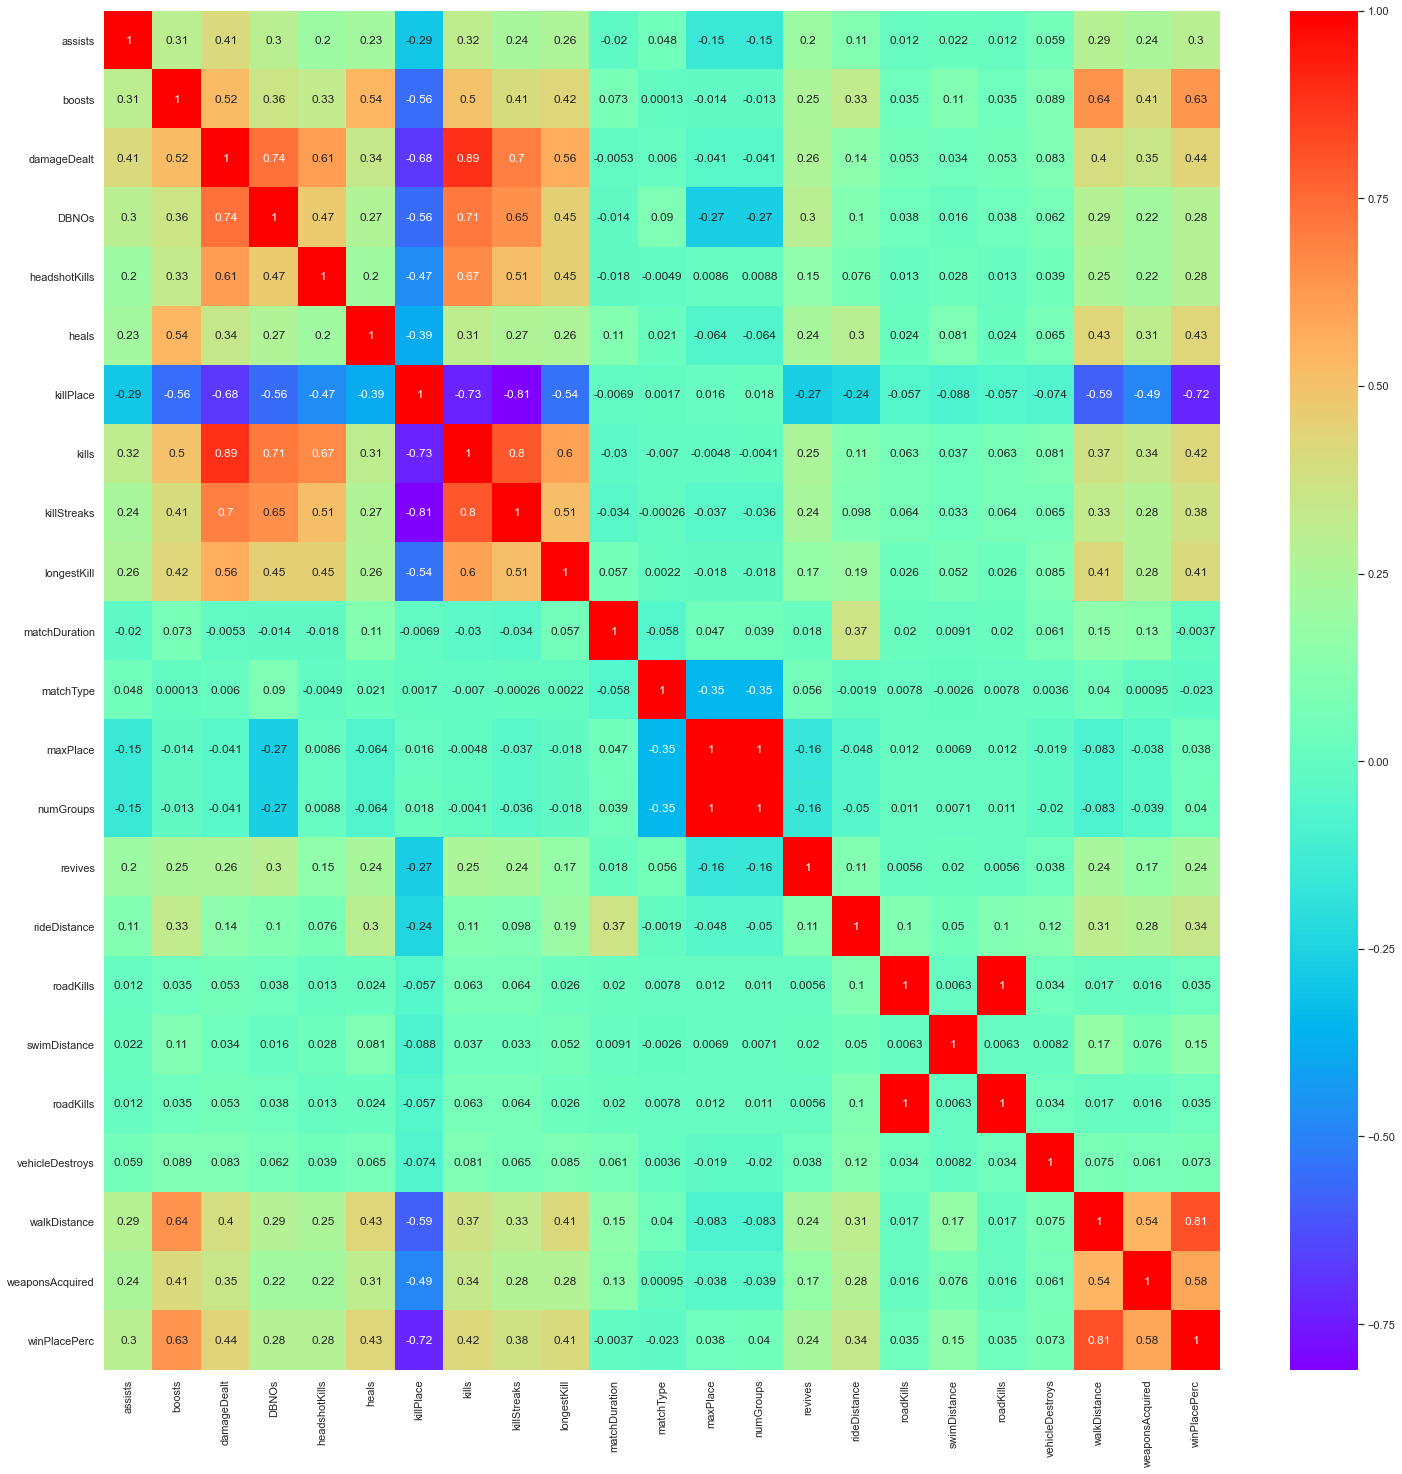

In [10]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(),cmap='rainbow',annot=True)


列出各个因素和winPlacePerc的相关性排序，并且选取前三名进行数据可视化：

In [11]:
df=data.corr()
df['winPlacePerc'].sort_values(ascending=False)[:4]

winPlacePerc       1.000000
walkDistance       0.811225
boosts             0.634694
weaponsAcquired    0.583727
Name: winPlacePerc, dtype: float64

发现最相关的四个因素分别是“步行距离”，“使用的提升类物品数”，“武器获得数”，“承受伤害量”

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='weaponsAcquired'>

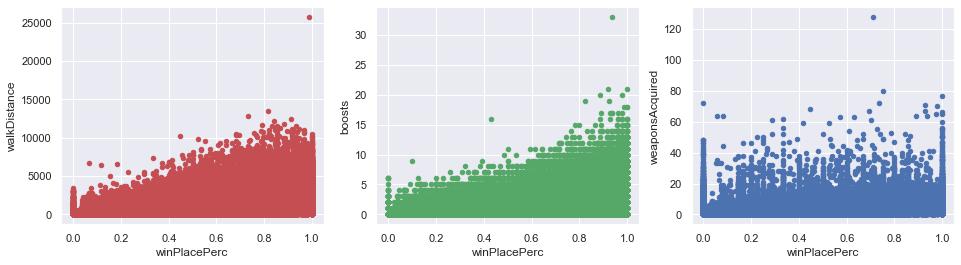

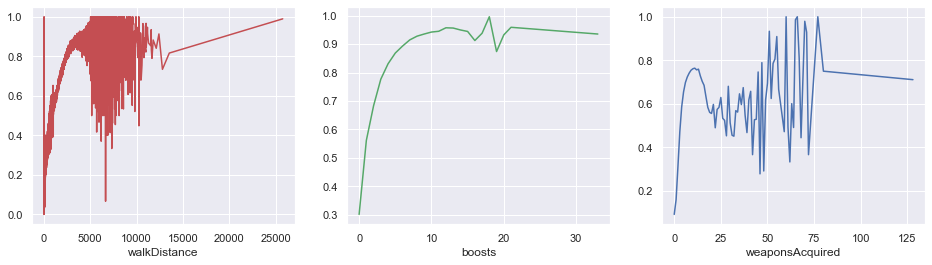

In [12]:
##点图
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
data.plot.scatter(y='walkDistance', x='winPlacePerc',c='r', ax=ax[0])
data.plot.scatter(y='boosts', x='winPlacePerc',c='g', ax=ax[1])
data.plot.scatter(y='weaponsAcquired', x='winPlacePerc', ax=ax[2])
#线图
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
data.groupby('walkDistance').mean()['winPlacePerc'].plot.line(ax=ax[0],c='r')
data.groupby('boosts').mean()['winPlacePerc'].plot.line(ax=ax[1],c='g')
data.groupby('weaponsAcquired').mean()['winPlacePerc'].plot.line(ax=ax[2],c='b')

从上图观察可知：

行走距离是和比赛排名最相关的因素。但是，不能断定，到底是排名影响了行走距离还是行走距离影响了比赛排名。可以发现的是，当行走距离从1000增长到5000左右，比赛的排名是从低水平迅速上升的，13000之后比赛的排位会在高水平稳定上升。其余的区段，比赛的排名波动比较大。当一个人的行走距离大于15000时，可以相对准确地猜测他的比赛排位会位于前20%。

使用提升类物品是第二关键的影响因素，当使用数量大于10时，可以比较有把握猜测他的排名会位于前10%。

第三类影响因素时武器获得量，但是从图中发现，它的变化特别杂乱，点图也没有特别明显的聚集性，因此在做不做评价。

当然影响一场比赛的因素是多个因素协同作用的，以上只是一个基于前馈神经网络的预测和基于可视化粗略分析。